# FEL BNN Training

This is an intial attempt at training BNNs to predict a median prediction with 95% confidence intervals for FEL photon pulse energy predictions.
This notebook is based heavily on the examples available in the blitz-bayesian-pytorch [documentation](https://pypi.org/project/blitz-bayesian-pytorch/).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [3]:
# full scale data
PATH = "knet2_76D/"
X_ = np.load(PATH +'X_fel.npy')  
Y_ = np.load(PATH +'Y_fel.npy')

In [4]:
mask=(Y_<5) & (Y_>=0.0)

Yf=Y_[mask]
Xf=X_[mask[:,0],:]

print("Input shape:" + str(Xf.shape))
print("Output shape:" + str(Yf.shape))

Input shape:(285068, 76)
Output shape:(285068,)


In [5]:
Xf = Xf[-150000:,:]
Yf = Yf[-150000:]

print("Input shape:" + str(Xf.shape))
print("Output shape:" + str(Yf.shape))

Input shape:(150000, 76)
Output shape:(150000,)


(array([13858., 15233., 20154., 20626., 24781., 22922., 16026., 12327.,
         3224.,   849.]),
 array([1.36673603e-06, 4.99433307e-01, 9.98865247e-01, 1.49829719e+00,
        1.99772913e+00, 2.49716107e+00, 2.99659301e+00, 3.49602495e+00,
        3.99545689e+00, 4.49488883e+00, 4.99432077e+00]),
 <BarContainer object of 10 artists>)

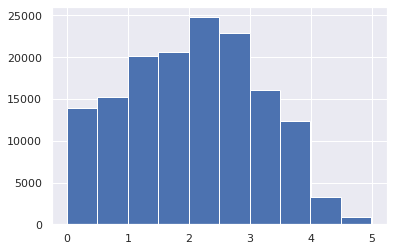

In [6]:
plt.hist(Yf)

In [7]:
scalerx = MinMaxScaler()
scalerx.fit(Xf)
xf=scalerx.transform(Xf)


Yf=Yf[:,np.newaxis]
scalery=MinMaxScaler()
scalery.fit(Yf)
yf=scalery.transform(Yf)



with open(PATH + "BNN/input_trans.pkl", 'wb') as f:
    pickle.dump(scalerx, f)

with open(PATH + "BNN/output_trans.pkl", 'wb') as f:
    pickle.dump(scalery, f)

def calc_mse_and_mae(meas, pred):
    mse = np.mean((meas - pred)**2)
    mae = np.mean(np.abs(meas-pred))
    return mse, mae

In [8]:
X_train, X_test, y_train, y_test = train_test_split(xf, yf, test_size=0.2, random_state=42)

In [9]:
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

In [10]:
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.blinear1 = BayesianLinear(input_dim, 80)
        self.blinear2 = BayesianLinear(80, 70)
        self.blinear3 = BayesianLinear(70, 60)
        self.blinear4 = BayesianLinear(60, 50)
        self.blinear5 = BayesianLinear(50, 40)
        self.blinear6 = BayesianLinear(40, 30)
        self.blinear7 = BayesianLinear(30, 20)
        self.blinear8 = BayesianLinear(20, 10)
        self.blinear9 = BayesianLinear(10, output_dim)
        
    def forward(self, x):
        x_ = self.blinear1(x)
        x_=self.blinear2(x_)
        x_=self.blinear3(x_)
        x_=self.blinear4(x_)
        x_=self.blinear5(x_)
        x_=self.blinear6(x_)
        x_=self.blinear7(x_)
        x_=self.blinear8(x_)
        return self.blinear9(x_)
    
    
    

In [11]:
def evaluate_regression(regressor,
                        X,
                        y,
                        samples = 100,
                        std_multiplier = 2):
    preds = [regressor(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    ic_acc = (ci_lower <= y) * (ci_upper >= y)
    ic_acc = ic_acc.float().mean()
    return ic_acc, (ci_upper >= y).float().mean(), (ci_lower <= y).float().mean()

CI acc: 0.00, CI upper acc: 0.00, CI lower acc: 1.00
CI acc: 0.00, CI upper acc: 0.00, CI lower acc: 1.00
CI acc: 0.00, CI upper acc: 0.02, CI lower acc: 0.98
CI acc: 0.01, CI upper acc: 0.15, CI lower acc: 0.86
CI acc: 0.02, CI upper acc: 0.36, CI lower acc: 0.65
CI acc: 0.02, CI upper acc: 0.48, CI lower acc: 0.53
CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.52
CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.51
CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.51
CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.51
CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.51
CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.51
CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.51
CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.51
CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.51
CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.51
CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.51
CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.51
CI acc: 0.02, CI upper acc: 0.51, CI lower acc

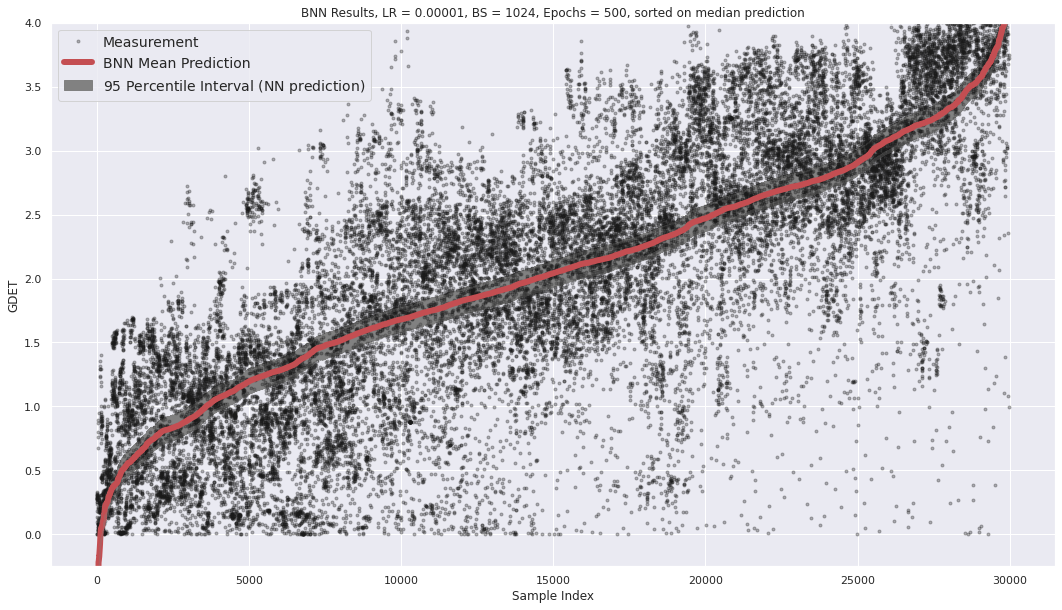

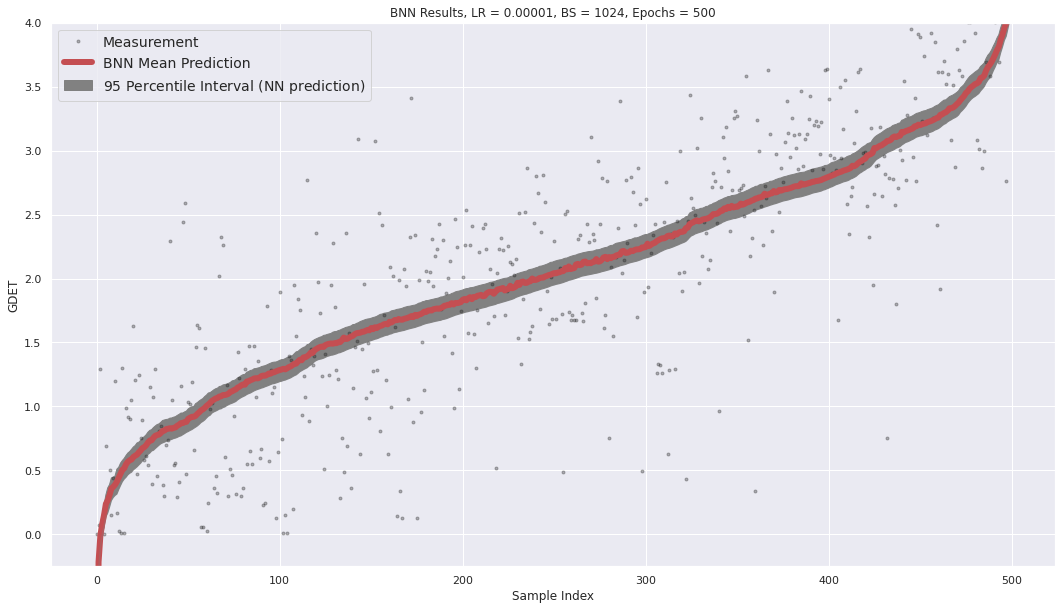

MSE = 0.43
MAE = 0.51


NameError: name 'model' is not defined

In [12]:
SAVEPATH = PATH + "BNN/model1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regressor = BayesianRegressor(76, 1).to(device)
optimizer = optim.Adam(regressor.parameters(), lr=0.00001)
criterion = torch.nn.MSELoss()


ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=1024, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=1024, shuffle=True)


iteration = 0
for epoch in range(500):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = regressor.sample_elbo(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=3,
                           complexity_cost_weight=1/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%100==0:
            ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
                                                                        X_test.to(device),
                                                                        y_test.to(device),
                                                                        samples=200,
                                                                        std_multiplier=2)
            
            print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
            
ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
                                                            X_test.to(device),
                                                            y_test.to(device),
                                                            samples=200,
                                                            std_multiplier=2) 
print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_")
print("Final Coverage and Loss")
print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
print("Loss: {:.4f}".format(loss))
print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_")


num=100
tempnum=y_test.shape[0]
preds=np.zeros((tempnum,num))
for i in range(num):
    temp=regressor.forward(X_test)
    pred1=temp.detach().numpy()
    preds[:,i]=pred1[:,0]
tempmean=np.mean(preds,axis=1)

tempstd=np.std(preds,axis=1)
tempmean.shape,tempstd.shape
tempmedian=np.quantile(preds,0.5,axis=1)
temp075=np.quantile(preds,0.975,axis=1)
temp025=np.quantile(preds,0.025,axis=1)


yreals=scalery.inverse_transform(y_test)
ymedian=scalery.inverse_transform(tempmedian[:,np.newaxis])
yu=scalery.inverse_transform(temp075[:,np.newaxis])
yl=scalery.inverse_transform(temp025[:,np.newaxis])


idx=np.argsort(ymedian[:,0])
base=np.arange(len(idx))
lower=yl[idx,0]
upper=yu[idx,0]


plt.figure(figsize=(18,10))
plt.title("BNN Results, LR = 0.00001, BS = 1024, Epochs = 500, sorted on median prediction")
plt.plot(yreals[idx,0],'.k',alpha=0.3,label="Measurement")
plt.plot(ymedian[idx,0],'r',linewidth=6,label="BNN Mean Prediction")
plt.plot(yu[idx,0],'grey',linewidth=0.1,alpha=0.3)
plt.fill_between(base,lower,upper, color='grey', alpha=0.99,label="$95$ Percentile Interval (NN prediction)") 
plt.plot(yl[idx,0],'grey',alpha=0.3)
plt.ylim(-0.25,4)
plt.xlabel('Sample Index')
plt.ylabel('GDET')
plt.legend(prop={'size': 14})
plt.show()


lbinds = np.argsort(yl[:,0])
ubinds = np.argsort(yu[:,0])

n = 500
seq = []
step = int(yu.shape[0]/n)

for i in range(n):
        temp1=lbinds[i*step:(i+1)*step]
        temp2=ubinds[i*step:(i+1)*step]
        for num in temp1:
            if(num in temp2):
                seq.append(num)
                break
                



base=np.arange(len(seq))
lower=yl[seq,0]
upper=yu[seq,0]


plt.figure(figsize=(18,10))
plt.title("BNN Results, LR = 0.00001, BS = 1024, Epochs = 500")
plt.plot(yreals[seq,0],'.k',alpha=0.3,label="Measurement")
plt.plot(ymedian[seq,0],'r',linewidth=6,label="BNN Mean Prediction")
plt.plot(yu[seq,0],'grey',linewidth=0.1,alpha=0.3)
plt.fill_between(base,lower,upper, color='grey', alpha=0.99,label="$95$ Percentile Interval (NN prediction)") 
plt.plot(yl[seq,0],'grey',alpha=0.3)
plt.ylim(-0.25,4)
plt.xlabel('Sample Index')
plt.ylabel('GDET')
plt.legend(prop={'size': 14})
plt.show()


mse, mae = calc_mse_and_mae(yreals, ymedian)
print("MSE = {:2.2f}".format(mse))
print("MAE = {:2.2f}".format(mae))

torch.save(regressor.state_dict(), SAVEPATH)

In [13]:
torch.save(regressor.state_dict(), SAVEPATH)

CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.51
CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.51
CI acc: 0.02, CI upper acc: 0.50, CI lower acc: 0.52
CI acc: 0.02, CI upper acc: 0.50, CI lower acc: 0.53
CI acc: 0.03, CI upper acc: 0.49, CI lower acc: 0.54
CI acc: 0.03, CI upper acc: 0.49, CI lower acc: 0.54
CI acc: 0.04, CI upper acc: 0.46, CI lower acc: 0.58
CI acc: 0.04, CI upper acc: 0.47, CI lower acc: 0.57
CI acc: 0.05, CI upper acc: 0.48, CI lower acc: 0.56
CI acc: 0.05, CI upper acc: 0.52, CI lower acc: 0.53
CI acc: 0.05, CI upper acc: 0.45, CI lower acc: 0.60
CI acc: 0.06, CI upper acc: 0.45, CI lower acc: 0.61
CI acc: 0.06, CI upper acc: 0.48, CI lower acc: 0.58
CI acc: 0.06, CI upper acc: 0.52, CI lower acc: 0.54
CI acc: 0.06, CI upper acc: 0.52, CI lower acc: 0.54
CI acc: 0.06, CI upper acc: 0.53, CI lower acc: 0.53
CI acc: 0.06, CI upper acc: 0.45, CI lower acc: 0.62
CI acc: 0.07, CI upper acc: 0.53, CI lower acc: 0.54
CI acc: 0.08, CI upper acc: 0.50, CI lower acc

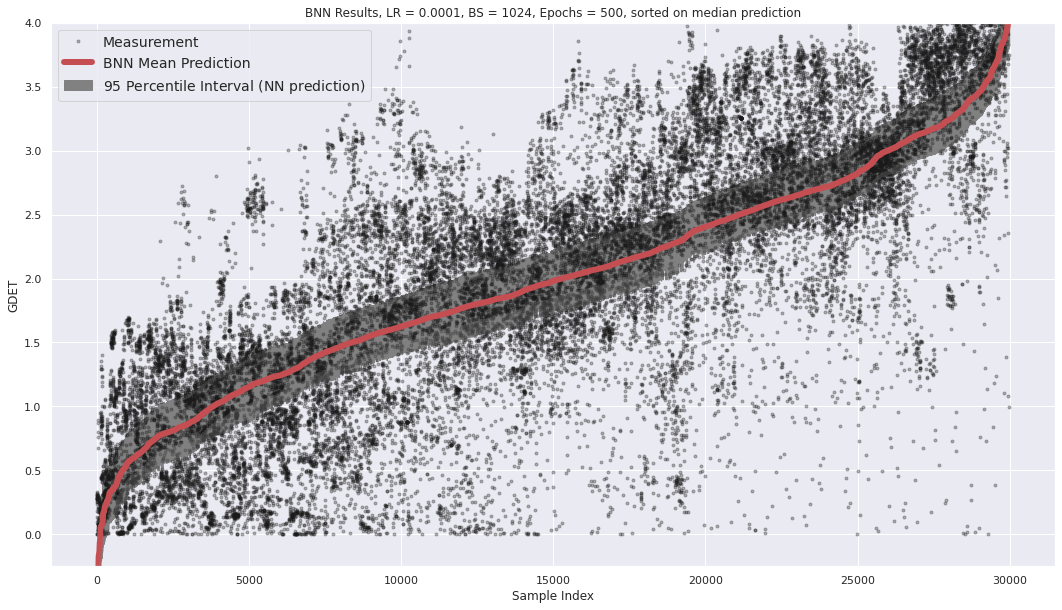

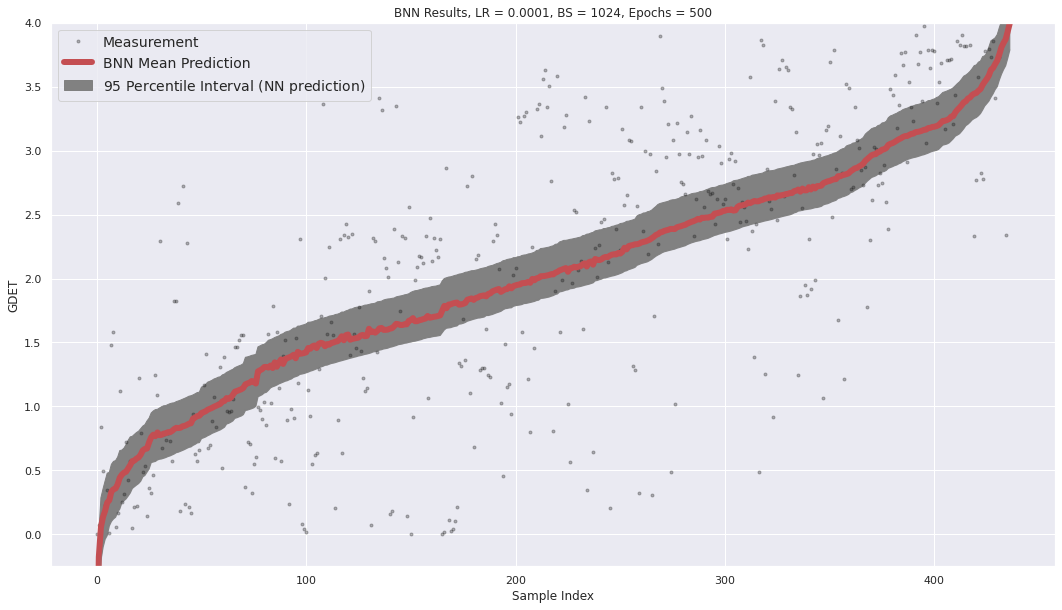

MSE = 0.44
MAE = 0.52


In [14]:
SAVEPATH = PATH + "BNN/model2"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regressor = BayesianRegressor(76, 1).to(device)
optimizer = optim.Adam(regressor.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()


ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=1024, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=1024, shuffle=True)


iteration = 0
for epoch in range(500):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = regressor.sample_elbo(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=3,
                           complexity_cost_weight=1/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%100==0:
            ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
                                                                        X_test.to(device),
                                                                        y_test.to(device),
                                                                        samples=200,
                                                                        std_multiplier=2)
            
            print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
            
ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
                                                            X_test.to(device),
                                                            y_test.to(device),
                                                            samples=200,
                                                            std_multiplier=2) 
print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_")
print("Final Coverage and Loss")
print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
print("Loss: {:.4f}".format(loss))
print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_")


num=100
tempnum=y_test.shape[0]
preds=np.zeros((tempnum,num))
for i in range(num):
    temp=regressor.forward(X_test)
    pred1=temp.detach().numpy()
    preds[:,i]=pred1[:,0]
tempmean=np.mean(preds,axis=1)

tempstd=np.std(preds,axis=1)
tempmean.shape,tempstd.shape
tempmedian=np.quantile(preds,0.5,axis=1)
temp075=np.quantile(preds,0.975,axis=1)
temp025=np.quantile(preds,0.025,axis=1)


yreals=scalery.inverse_transform(y_test)
ymedian=scalery.inverse_transform(tempmedian[:,np.newaxis])
yu=scalery.inverse_transform(temp075[:,np.newaxis])
yl=scalery.inverse_transform(temp025[:,np.newaxis])


idx=np.argsort(ymedian[:,0])
base=np.arange(len(idx))
lower=yl[idx,0]
upper=yu[idx,0]


plt.figure(figsize=(18,10))
plt.title("BNN Results, LR = 0.0001, BS = 1024, Epochs = 500, sorted on median prediction")
plt.plot(yreals[idx,0],'.k',alpha=0.3,label="Measurement")
plt.plot(ymedian[idx,0],'r',linewidth=6,label="BNN Mean Prediction")
plt.plot(yu[idx,0],'grey',linewidth=0.1,alpha=0.3)
plt.fill_between(base,lower,upper, color='grey', alpha=0.99,label="$95$ Percentile Interval (NN prediction)") 
plt.plot(yl[idx,0],'grey',alpha=0.3)
plt.ylim(-0.25,4)
plt.xlabel('Sample Index')
plt.ylabel('GDET')
plt.legend(prop={'size': 14})
plt.show()


lbinds = np.argsort(yl[:,0])
ubinds = np.argsort(yu[:,0])

n = 500
seq = []
step = int(yu.shape[0]/n)

for i in range(n):
        temp1=lbinds[i*step:(i+1)*step]
        temp2=ubinds[i*step:(i+1)*step]
        for num in temp1:
            if(num in temp2):
                seq.append(num)
                break
                



base=np.arange(len(seq))
lower=yl[seq,0]
upper=yu[seq,0]


plt.figure(figsize=(18,10))
plt.title("BNN Results, LR = 0.0001, BS = 1024, Epochs = 500")
plt.plot(yreals[seq,0],'.k',alpha=0.3,label="Measurement")
plt.plot(ymedian[seq,0],'r',linewidth=6,label="BNN Mean Prediction")
plt.plot(yu[seq,0],'grey',linewidth=0.1,alpha=0.3)
plt.fill_between(base,lower,upper, color='grey', alpha=0.99,label="$95$ Percentile Interval (NN prediction)") 
plt.plot(yl[seq,0],'grey',alpha=0.3)
plt.ylim(-0.25,4)
plt.xlabel('Sample Index')
plt.ylabel('GDET')
plt.legend(prop={'size': 14})
plt.show()


mse, mae = calc_mse_and_mae(yreals, ymedian)
print("MSE = {:2.2f}".format(mse))
print("MAE = {:2.2f}".format(mae))

torch.save(regressor.state_dict(), SAVEPATH)

CI acc: 0.02, CI upper acc: 0.49, CI lower acc: 0.52
CI acc: 0.02, CI upper acc: 0.51, CI lower acc: 0.52
CI acc: 0.03, CI upper acc: 0.49, CI lower acc: 0.54
CI acc: 0.03, CI upper acc: 0.49, CI lower acc: 0.54
CI acc: 0.03, CI upper acc: 0.50, CI lower acc: 0.53
CI acc: 0.03, CI upper acc: 0.52, CI lower acc: 0.52
CI acc: 0.04, CI upper acc: 0.51, CI lower acc: 0.53
CI acc: 0.04, CI upper acc: 0.51, CI lower acc: 0.53
CI acc: 0.04, CI upper acc: 0.50, CI lower acc: 0.55
CI acc: 0.05, CI upper acc: 0.48, CI lower acc: 0.56
CI acc: 0.05, CI upper acc: 0.48, CI lower acc: 0.57
CI acc: 0.06, CI upper acc: 0.46, CI lower acc: 0.60
CI acc: 0.06, CI upper acc: 0.47, CI lower acc: 0.59
CI acc: 0.06, CI upper acc: 0.47, CI lower acc: 0.59
CI acc: 0.07, CI upper acc: 0.53, CI lower acc: 0.54
CI acc: 0.07, CI upper acc: 0.48, CI lower acc: 0.59
CI acc: 0.06, CI upper acc: 0.43, CI lower acc: 0.64
CI acc: 0.08, CI upper acc: 0.49, CI lower acc: 0.59
CI acc: 0.08, CI upper acc: 0.47, CI lower acc

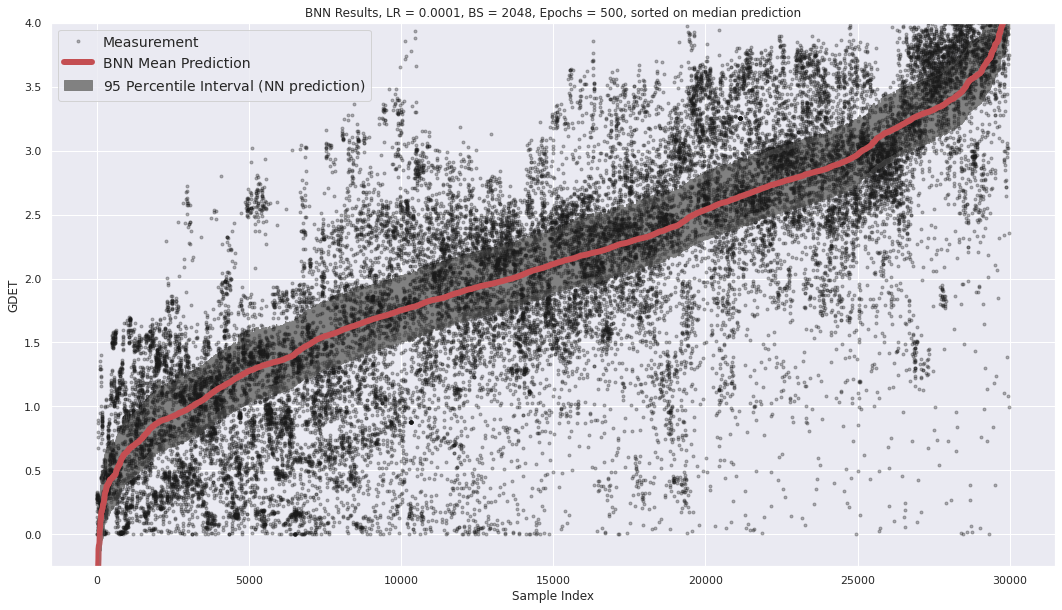

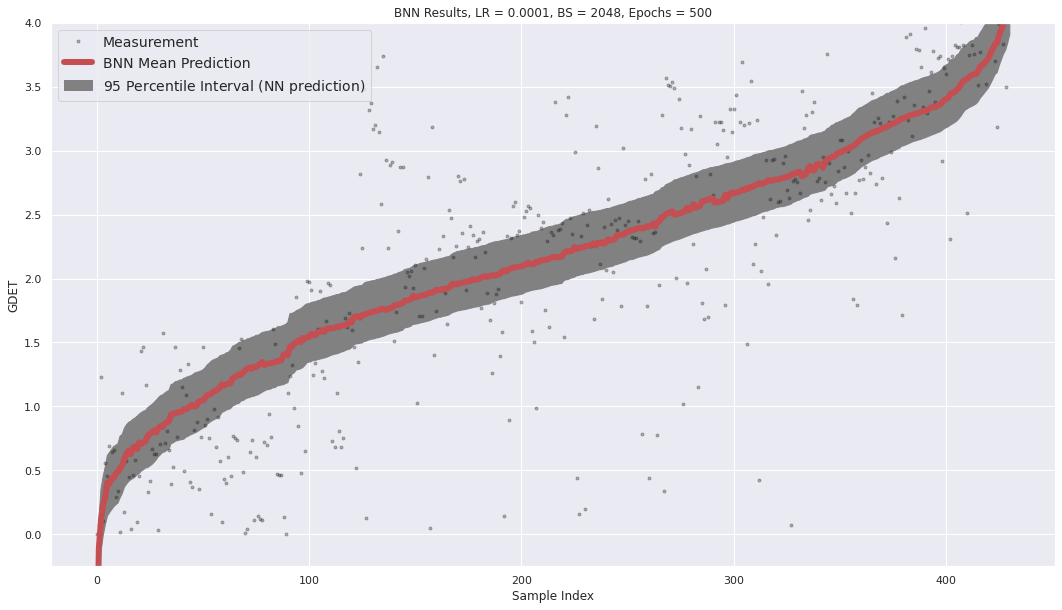

MSE = 0.43
MAE = 0.50


In [15]:
SAVEPATH = PATH + "BNN/model3"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regressor = BayesianRegressor(76, 1).to(device)
optimizer = optim.Adam(regressor.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()


ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=1024, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=1024, shuffle=True)


iteration = 0
for epoch in range(500):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = regressor.sample_elbo(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=3,
                           complexity_cost_weight=1/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%100==0:
            ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
                                                                        X_test.to(device),
                                                                        y_test.to(device),
                                                                        samples=200,
                                                                        std_multiplier=2)
            
            print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
            
ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
                                                            X_test.to(device),
                                                            y_test.to(device),
                                                            samples=200,
                                                            std_multiplier=2) 
print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_")
print("Final Coverage and Loss")
print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
print("Loss: {:.4f}".format(loss))
print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_")


num=100
tempnum=y_test.shape[0]
preds=np.zeros((tempnum,num))
for i in range(num):
    temp=regressor.forward(X_test)
    pred1=temp.detach().numpy()
    preds[:,i]=pred1[:,0]
tempmean=np.mean(preds,axis=1)

tempstd=np.std(preds,axis=1)
tempmean.shape,tempstd.shape
tempmedian=np.quantile(preds,0.5,axis=1)
temp075=np.quantile(preds,0.975,axis=1)
temp025=np.quantile(preds,0.025,axis=1)


yreals=scalery.inverse_transform(y_test)
ymedian=scalery.inverse_transform(tempmedian[:,np.newaxis])
yu=scalery.inverse_transform(temp075[:,np.newaxis])
yl=scalery.inverse_transform(temp025[:,np.newaxis])


idx=np.argsort(ymedian[:,0])
base=np.arange(len(idx))
lower=yl[idx,0]
upper=yu[idx,0]


plt.figure(figsize=(18,10))
plt.title("BNN Results, LR = 0.0001, BS = 2048, Epochs = 500, sorted on median prediction")
plt.plot(yreals[idx,0],'.k',alpha=0.3,label="Measurement")
plt.plot(ymedian[idx,0],'r',linewidth=6,label="BNN Mean Prediction")
plt.plot(yu[idx,0],'grey',linewidth=0.1,alpha=0.3)
plt.fill_between(base,lower,upper, color='grey', alpha=0.99,label="$95$ Percentile Interval (NN prediction)") 
plt.plot(yl[idx,0],'grey',alpha=0.3)
plt.ylim(-0.25,4)
plt.xlabel('Sample Index')
plt.ylabel('GDET')
plt.legend(prop={'size': 14})
plt.show()


lbinds = np.argsort(yl[:,0])
ubinds = np.argsort(yu[:,0])

n = 500
seq = []
step = int(yu.shape[0]/n)

for i in range(n):
        temp1=lbinds[i*step:(i+1)*step]
        temp2=ubinds[i*step:(i+1)*step]
        for num in temp1:
            if(num in temp2):
                seq.append(num)
                break
                



base=np.arange(len(seq))
lower=yl[seq,0]
upper=yu[seq,0]


plt.figure(figsize=(18,10))
plt.title("BNN Results, LR = 0.0001, BS = 2048, Epochs = 500")
plt.plot(yreals[seq,0],'.k',alpha=0.3,label="Measurement")
plt.plot(ymedian[seq,0],'r',linewidth=6,label="BNN Mean Prediction")
plt.plot(yu[seq,0],'grey',linewidth=0.1,alpha=0.3)
plt.fill_between(base,lower,upper, color='grey', alpha=0.99,label="$95$ Percentile Interval (NN prediction)") 
plt.plot(yl[seq,0],'grey',alpha=0.3)
plt.ylim(-0.25,4)
plt.xlabel('Sample Index')
plt.ylabel('GDET')
plt.legend(prop={'size': 14})
plt.show()


mse, mae = calc_mse_and_mae(yreals, ymedian)
print("MSE = {:2.2f}".format(mse))
print("MAE = {:2.2f}".format(mae))

torch.save(regressor.state_dict(), SAVEPATH)